# Introduction

In this notebook, we will predict the remaining useful life (RUL) of a battery and visualize the prediction uncertainty by using a visualization technique called hypothetical outcome plots. 

Towards that end, we will create an animation that displays various possible battery degradation trajectories. For this prognostic case study, we adopted a data-driven approach, which trains a statistical model to approximate the relationship between time and battery degradation state, thus allowing us to estimate the remaining useful life (RUL) of the battery.

In this case study, we will demonstrate how hypothetical outcome plots highlight the **risk** of battery failure after certain usage time. This could be especially helpful when communicating prediction uncertainties to decision-makers, as hypothetical outcome plots allow decision-makers to directly *experience* risk, which would otherwise be asbtract and hard to interpret.

In [2]:
# import all packages and set plots to be embedded inline
import numpy as np
from scipy.integrate import quad
import sklearn.gaussian_process as gp
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
from celluloid import Camera
import pandas as pd
import os

%matplotlib inline
np.set_printoptions(precision=2,suppress=True)
np.random.seed(42)

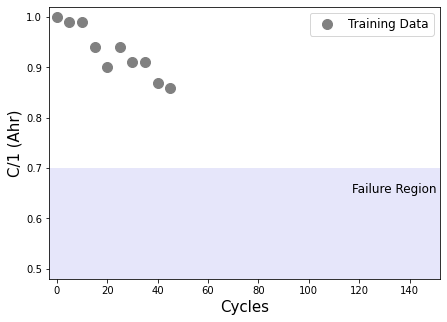

In [23]:
# Training data
X_train = np.arange(0,46,5)
y_train = np.array([1.,0.99,0.99,0.94,0.9,0.94,0.91,0.91,0.87,0.86])


# Visualizing training data
fig, ax = plt.subplots(figsize=(7,5))
ax.set(xlim=(-3, 152), ylim=(0.48, 1.02))
ax.plot(X_train,y_train,'o',color=(0.5,0.5,0.5),markerfacecolor=(0.5,0.5,0.5),markersize=10,label='Training Data')

# Risk region
shade_x = np.arange(-3,153)
shade_upper = 0.7*np.ones(shade_x.shape[0])
shade_lower = 0.46*np.ones(shade_x.shape[0])
ax.fill_between(shade_x, shade_upper, shade_lower,facecolor='lavender')
ax.text(117,0.65,'Failure Region', fontsize=12)

# Figure settings
ax.set_xlabel('Cycles', fontsize=15)
ax.set_ylabel('C/1 (Ahr)', fontsize=15)
ax.legend(loc="upper right",prop={'size': 12})

In [22]:
# Train Gaussian Process (GP) model
kernel = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(1.0, (1e-3, 1e3))
model = gp.GaussianProcessRegressor(kernel=kernel, 
                                    optimizer='fmin_l_bfgs_b',
                                    n_restarts_optimizer=30, 
                                    alpha=0.4, 
                                    normalize_y=True)
model.fit(X_train.reshape((-1, 1)), y_train.reshape((-1, 1)))

GaussianProcessRegressor(alpha=0.4, kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=30, normalize_y=True)

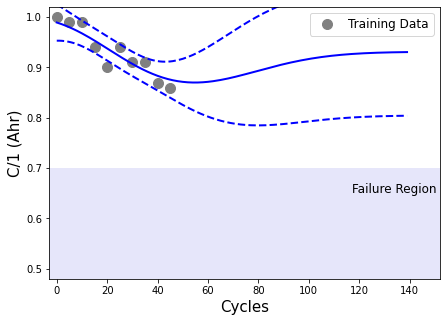

In [24]:
# GP prediction
X_test = np.arange(0, 140, 1)
y_pred, pred_cov = model.predict(X_test.reshape((-1, 1)), return_cov=True)
y_pred = np.ravel(y_pred)

# Prediction standard deviation
pred_std = np.sqrt(np.diag(pred_cov))

# Visualizing GP prediction
ax.plot(X_test,y_pred,'b-',lw=2,label='GP Prediction')
ax.plot(X_test,y_pred+1.96*pred_std,'b--',lw=2,label='95% Credibility Interval')
ax.plot(X_test,y_pred-1.96*pred_std,'b--',lw=2,label='95% Credibility Interval')
fig